In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Создание датафрейма из таблицы с объемом кредитов

In [262]:
df =  pd.read_excel('stat_bulletin_lending_24-01_45.xlsx', sheet_name = 'Таблица 1', skiprows = 2)
df.to_csv("Test.csv")
replace_text = ' '
for i in range(1, len(df.columns)): 
    if df.columns[i] == 'Unnamed: ' + str(i):
        if count==0:
            replace_text = df.columns.values[i-1] 
            df.columns.values[i-1] = df.columns.values[i-1] + '<>' + df.iloc[0][i-1]
        df.columns.values[i] = replace_text + '<>' + df.iloc[0][i]
        count += 1
    else:
        count = 0

df = df.drop(0, axis = 0)
df

C:\Users\Дарья\AppData\Local\Temp\ipykernel_17804\1761153791.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.columns.values[i-1] = df.columns.values[i-1] + '<>' + df.iloc[0][i-1]
C:\Users\Дарья\AppData\Local\Temp\ipykernel_17804\1761153791.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.columns.values[i] = replace_text + '<>' + df.iloc[0][i]


,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в рублях","Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в иностранной валюте","Количество кредитов, предоставленных субъектам МСП, в рублях и иностранной валюте, ед.","Средний размер кредита субъектов МСП, млн руб.","Количество субъектов МСП, получивших кредит в отчетном месяце, ед."
1,Январь 2022 г.,800529,798524,2006,181204.0,4.4,163871.0
2,Февраль 2022 г.,964639,960168,4471,201384.0,4.8,179660.0
3,Март 2022 г.,816031,815581,450,171437.0,4.8,157676.0
4,Апрель 2022 г.,808912,784373,24539,166472.0,4.9,151661.0
5,Май 2022 г.,676283,663850,12433,167614.0,4.0,152422.0
6,Июнь 2022 г.,944500,944318,182,182677.0,5.2,163929.0
7,Июль 2022 г.,926997,836025,90972,178479.0,5.2,159839.0
8,Август 2022 г.,959111,921727,37384,186475.0,5.1,166101.0
9,Сентябрь 2022 г.,1087392,1029413,57979,191022.0,5.7,169842.0
10,Октябрь 2022 г.,1105843,1105443,400,186379.0,5.9,166647.0


In [263]:
df['Отчетный период'] = df['Отчетный период'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 1 to 25
Data columns (total 7 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Отчетный период                                                                            25 non-null     object 
 1   Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего                             25 non-null     object 
 2   Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в рублях              25 non-null     object 
 3   Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в иностранной валюте  25 non-null     object 
 4   Количество кредитов, предоставленных субъектам МСП, в рублях и иностранной валюте, ед.     25 non-null     float64
 5   Средний размер кредита субъектов МСП, млн руб.       

In [264]:
df = df[['Отчетный период', 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column                                                          Non-Null Count  Dtype 
---  ------                                                          --------------  ----- 
 0   Отчетный период                                                 25 non-null     object
 1   Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего  25 non-null     object
dtypes: object(2)
memory usage: 532.0+ bytes


Создание датафрейма из таблицы с макропараметрами

In [265]:
df_par =  pd.read_excel('2. Макро_базовый.xlsx', skiprows = 4)
df_par.to_csv("Test2.csv")
df_par = df_par.drop('Unnamed: 1', axis = 1)
df_par = df_par.transpose()
df_par = df_par.reset_index()
df_par.rename(columns = {'index': 'Отчетный период'}, inplace = True)
df_par = df_par.drop(0, axis = 1)

for i in range(1, len(df_par.columns)): 
    if df_par.iloc[0][i] == '* ВВП в 2022 году учитывает экономическую активность, связанную с новыми территориями ** Показатели будут уточнены по мере выхода официальной статистической информации по Донецкой Народной Республике (ДНР), Луганской  Народной Республике (ЛНР), Запорожской и Херсонской областям в соответствии с Федеральным планом статистических работ, утвержденным распоряжением Правительства Российской Федерации от 6 мая 2008 г. № 671-р':
        df_par = df_par.drop(i, axis = 1)
    if df_par.iloc[0][i] == '** Показатели будут уточнены по мере выхода официальной статистической информации по Донецкой Народной Республике (ДНР), Луганской  Народной Республике (ЛНР), Запорожской и Херсонской областям в соответствии с Федеральным планом статистических работ, утвержденным распоряжением Правительства Российской Федерации от 6 мая 2008 г. № 671-р':
        df_par = df_par.drop(i, axis = 1)
    

    
column_names_par = df_par.columns.tolist()
replace_text_par = ' '
for i in range(1, len(df_par.columns)): 
    if pd.isna(df_par.iloc[1][i]):
        replace_text_par = df_par.iloc[0][i]
        column_names_par[i] = 'Delete' + str(i)
    else:
        if i>1 and i < (len(df_par.columns) - 7):
            column_names_par[i] = replace_text_par + '<>' + df_par.iloc[0][i]
        else:
            column_names_par[i] = df_par.iloc[0][i]

df_par = df_par.drop(0, axis = 0)
df_par.columns = column_names_par
            
df_par = df_par[[col for col in df_par.columns if not col.startswith('Delete')]]
df_par = df_par.drop(5, axis = 0) # удаляем 2026 год           
df_par

,Отчетный период,"Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Торговый баланс<> к ВВП,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС
1,2022,79.6195,111.94,113.75,153435,153435.1528,97.9,115.8,102547.556,100.6,...,13.8101,236.0771,10.3789,74.9242,71.9736,2.9507,3.9382,97.5543,67.4562,3470.052542
2,2023,63.4057,107.534,105.8115,166015.075882,163981.9275,102.8295,103.933,108951.6706,103.57284,...,7.5524,74.3564,3.8643,75.1515,72.7994,2.3521,3.1298,101.6631,85.2212,4125.595338
3,2024,71.3111,104.5421,107.1615,179956.175591,177557.0605,102.2589,105.8865,121532.7169,102.553429,...,7.6805,80.7495,4.0987,75.6172,73.2651,2.3521,3.1106,101.6088,90.1244,4301.15374
4,2025,70.1012,104.0395,104.1663,190637.073105,187854.0996,102.2632,103.4578,127837.6622,102.213447,...,7.4833,77.7687,3.7726,76.109,73.7568,2.3521,3.0905,101.5814,91.1288,4088.02769


In [266]:
# Создаем список для хранения данных 
all_rows = []

# Итерируемся по строкам (годам) в исходном DataFrame
for j in range(len(df_par) - 1):
    # Итерируемся по месяцам в обратном порядке
    for month in range(12, 0, -1):
        # Создаем словарь для хранения данных за месяц
        row = {'Отчетный период': pd.to_datetime(f"{df_par.iloc[j, 0]}-{month:02d}")}

        # Итерируемся по столбцам (показателям)
        for i in range(1, len(df_par.columns)):
            # Получаем имя столбца
            col_name = df_par.columns[i]

            # Значение за январь текущего года (принимаем за базу)
            start_value = float(df_par.iloc[j, i])

            # Разница между значениями за два года
            difference = float(df_par.iloc[j + 1, i] - start_value)

            # Вычисляем значение для текущего месяца
            value = start_value + (difference / 12) * (12 - month)

            # Добавляем значение в словарь row
            row[col_name] = value

        # Добавляем словарь в список всех строк
        all_rows.append(row)

# Создаем DataFrame из списка словарей
df_monthly = pd.DataFrame(all_rows, columns = df_par.columns)

# Сортируем DataFrame по дате
df_monthly = df_monthly.sort_values(by='Отчетный период').reset_index(drop=True)
df_monthly

,Отчетный период,"Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Торговый баланс<> к ВВП,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС
0,2022-01-01,64.756850,107.901167,106.473042,164966.736225,163103.029608,102.418708,104.921917,108417.994383,103.325103,...,8.073875,87.833125,4.407183,75.132558,72.730583,2.401983,3.197167,101.320700,83.740783,4070.966771
1,2022-02-01,66.108000,108.268333,107.134583,163918.396568,162224.131717,102.007917,105.910833,107884.318167,103.077367,...,8.595350,101.309850,4.950067,75.113617,72.661767,2.451867,3.264533,100.978300,82.260367,4016.338205
2,2022-03-01,67.459150,108.635500,107.796125,162870.056911,161345.233825,101.597125,106.899750,107350.641950,102.829630,...,9.116825,114.786575,5.492950,75.094675,72.592950,2.501750,3.331900,100.635900,80.779950,3961.709639
3,2022-04-01,68.810300,109.002667,108.457667,161821.717255,160466.335933,101.186333,107.888667,106816.965733,102.581893,...,9.638300,128.263300,6.035833,75.075733,72.524133,2.551633,3.399267,100.293500,79.299533,3907.081072
4,2022-05-01,70.161450,109.369833,109.119208,160773.377598,159587.438042,100.775542,108.877583,106283.289517,102.334157,...,10.159775,141.740025,6.578717,75.056792,72.455317,2.601517,3.466633,99.951100,77.819117,3852.452506
5,2022-06-01,71.512600,109.737000,109.780750,159725.037941,158708.540150,100.364750,109.866500,105749.613300,102.086420,...,10.681250,155.216750,7.121600,75.037850,72.386500,2.651400,3.534000,99.608700,76.338700,3797.823940
6,2022-07-01,72.863750,110.104167,110.442292,158676.698284,157829.642258,99.953958,110.855417,105215.937083,101.838683,...,11.202725,168.693475,7.664483,75.018908,72.317683,2.701283,3.601367,99.266300,74.858283,3743.195374
7,2022-08-01,74.214900,110.471333,111.103833,157628.358627,156950.744367,99.543167,111.844333,104682.260867,101.590947,...,11.724200,182.170200,8.207367,74.999967,72.248867,2.751167,3.668733,98.923900,73.377867,3688.566807
8,2022-09-01,75.566050,110.838500,111.765375,156580.018970,156071.846475,99.132375,112.833250,104148.584650,101.343210,...,12.245675,195.646925,8.750250,74.981025,72.180050,2.801050,3.736100,98.581500,71.897450,3633.938241
9,2022-10-01,76.917200,111.205667,112.426917,155531.679314,155192.948583,98.721583,113.822167,103614.908433,101.095473,...,12.767150,209.123650,9.293133,74.962083,72.111233,2.850933,3.803467,98.239100,70.417033,3579.309675


Разобъем эти данные на выборку для прогноза и данные для дальнейшего обучения и тестирования

In [267]:
split_date = '2024-01-01'
train = df_monthly[df_monthly['Отчетный период'] <= split_date]
train = train.drop('Отчетный период', axis = 1)
data_for_predict = df_monthly[df_monthly['Отчетный период'] > split_date]
# Преобразуем столбец 'date' в формат datetime
data_for_predict['Отчетный период'] = pd.to_datetime(data_for_predict['Отчетный период'])
# Извлекаем номер месяца 
data_for_predict['Месяц'] = data_for_predict['Отчетный период'].dt.month
data_for_predict_in_memory = data_for_predict
data_for_predict = data_for_predict.drop('Отчетный период', axis = 1)
data_for_predict

C:\Users\Дарья\AppData\Local\Temp\ipykernel_17804\1294975347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_predict['Отчетный период'] = pd.to_datetime(data_for_predict['Отчетный период'])
C:\Users\Дарья\AppData\Local\Temp\ipykernel_17804\1294975347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_predict['Месяц'] = data_for_predict['Отчетный период'].dt.month


,"Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,Объем отгруженной продукции (работ. услуг) <> Индекс-дефлятор (по сопоставимому кругу предприятий),...,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС,Месяц
25,70.302850,104.123267,104.6655,188856.923519,186137.926417,102.262483,103.862583,126786.837983,102.270111,103.886667,...,78.2655,3.826950,76.027033,73.674850,2.3521,3.093850,101.585967,90.9614,4123.548698,2
26,70.403675,104.165150,104.9151,187966.848727,185279.839825,102.262125,104.064975,126261.425875,102.298443,104.375000,...,78.5139,3.854125,75.986050,73.633875,2.3521,3.095525,101.588250,90.8777,4141.309202,3
27,70.504500,104.207033,105.1647,187076.773934,184421.753233,102.261767,104.267367,125736.013767,102.326774,104.863333,...,78.7623,3.881300,75.945067,73.592900,2.3521,3.097200,101.590533,90.7940,4159.069706,4
28,70.605325,104.248917,105.4143,186186.699141,183563.666642,102.261408,104.469758,125210.601658,102.355106,105.351667,...,79.0107,3.908475,75.904083,73.551925,2.3521,3.098875,101.592817,90.7103,4176.830211,5
29,70.706150,104.290800,105.6639,185296.624348,182705.580050,102.261050,104.672150,124685.189550,102.383438,105.840000,...,79.2591,3.935650,75.863100,73.510950,2.3521,3.100550,101.595100,90.6266,4194.590715,6
30,70.806975,104.332683,105.9135,184406.549555,181847.493458,102.260692,104.874542,124159.777442,102.411770,106.328333,...,79.5075,3.962825,75.822117,73.469975,2.3521,3.102225,101.597383,90.5429,4212.351219,7
31,70.907800,104.374567,106.1631,183516.474762,180989.406867,102.260333,105.076933,123634.365333,102.440101,106.816667,...,79.7559,3.990000,75.781133,73.429000,2.3521,3.103900,101.599667,90.4592,4230.111723,8
32,71.008625,104.416450,106.4127,182626.399969,180131.320275,102.259975,105.279325,123108.953225,102.468433,107.305000,...,80.0043,4.017175,75.740150,73.388025,2.3521,3.105575,101.601950,90.3755,4247.872227,9
33,71.109450,104.458333,106.6623,181736.325176,179273.233683,102.259617,105.481717,122583.541117,102.496765,107.793333,...,80.2527,4.044350,75.699167,73.347050,2.3521,3.107250,101.604233,90.2918,4265.632732,10
34,71.210275,104.500217,106.9119,180846.250384,178415.147092,102.259258,105.684108,122058.129008,102.525097,108.281667,...,80.5011,4.071525,75.658183,73.306075,2.3521,3.108925,101.606517,90.2081,4283.393236,11


Объединим датафрейм с данными об объеме кредита с датафреймом с данными о макропараметрах

In [268]:
df_total = pd.concat([df, train], axis = 1)
df_total

,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,...,Торговый баланс<> к ВВП,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС
0,Январь 2022 г.,800529,64.756850,107.901167,106.473042,164966.736225,163103.029608,102.418708,104.921917,108417.994383,...,8.073875,87.833125,4.407183,75.132558,72.730583,2.401983,3.197167,101.320700,83.740783,4070.966771
1,Февраль 2022 г.,964639,66.108000,108.268333,107.134583,163918.396568,162224.131717,102.007917,105.910833,107884.318167,...,8.595350,101.309850,4.950067,75.113617,72.661767,2.451867,3.264533,100.978300,82.260367,4016.338205
2,Март 2022 г.,816031,67.459150,108.635500,107.796125,162870.056911,161345.233825,101.597125,106.899750,107350.641950,...,9.116825,114.786575,5.492950,75.094675,72.592950,2.501750,3.331900,100.635900,80.779950,3961.709639
3,Апрель 2022 г.,808912,68.810300,109.002667,108.457667,161821.717255,160466.335933,101.186333,107.888667,106816.965733,...,9.638300,128.263300,6.035833,75.075733,72.524133,2.551633,3.399267,100.293500,79.299533,3907.081072
4,Май 2022 г.,676283,70.161450,109.369833,109.119208,160773.377598,159587.438042,100.775542,108.877583,106283.289517,...,10.159775,141.740025,6.578717,75.056792,72.455317,2.601517,3.466633,99.951100,77.819117,3852.452506
5,Июнь 2022 г.,944500,71.512600,109.737000,109.780750,159725.037941,158708.540150,100.364750,109.866500,105749.613300,...,10.681250,155.216750,7.121600,75.037850,72.386500,2.651400,3.534000,99.608700,76.338700,3797.823940
6,Июль 2022 г.,926997,72.863750,110.104167,110.442292,158676.698284,157829.642258,99.953958,110.855417,105215.937083,...,11.202725,168.693475,7.664483,75.018908,72.317683,2.701283,3.601367,99.266300,74.858283,3743.195374
7,Август 2022 г.,959111,74.214900,110.471333,111.103833,157628.358627,156950.744367,99.543167,111.844333,104682.260867,...,11.724200,182.170200,8.207367,74.999967,72.248867,2.751167,3.668733,98.923900,73.377867,3688.566807
8,Сентябрь 2022 г.,1087392,75.566050,110.838500,111.765375,156580.018970,156071.846475,99.132375,112.833250,104148.584650,...,12.245675,195.646925,8.750250,74.981025,72.180050,2.801050,3.736100,98.581500,71.897450,3633.938241
9,Октябрь 2022 г.,1105843,76.917200,111.205667,112.426917,155531.679314,155192.948583,98.721583,113.822167,103614.908433,...,12.767150,209.123650,9.293133,74.962083,72.111233,2.850933,3.803467,98.239100,70.417033,3579.309675


In [269]:
month_mapping = {
    'Январь': 1,
    'Февраль': 2,
    'Март': 3,
    'Апрель': 4,
    'Май': 5,
    'Июнь': 6,
    'Июль': 7,
    'Август': 8,
    'Сентябрь': 9,
    'Октябрь': 10,
    'Ноябрь': 11,
    'Декабрь': 12
}

df_total['Месяц'] = df_total['Отчетный период'].str.split(' ').str[0].map(month_mapping)
df_total = df_total.drop('Отчетный период', axis = 1)
df_total.head()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС,Месяц
0,800529,64.75685,107.901167,106.473042,164966.736225,163103.029608,102.418708,104.921917,108417.994383,103.325103,...,87.833125,4.407183,75.132558,72.730583,2.401983,3.197167,101.3207,83.740783,4070.966771,1
1,964639,66.10800,108.268333,107.134583,163918.396568,162224.131717,102.007917,105.910833,107884.318167,103.077367,...,101.309850,4.950067,75.113617,72.661767,2.451867,3.264533,100.9783,82.260367,4016.338205,2
2,816031,67.45915,108.635500,107.796125,162870.056911,161345.233825,101.597125,106.899750,107350.641950,102.829630,...,114.786575,5.492950,75.094675,72.592950,2.501750,3.331900,100.6359,80.779950,3961.709639,3
3,808912,68.81030,109.002667,108.457667,161821.717255,160466.335933,101.186333,107.888667,106816.965733,102.581893,...,128.263300,6.035833,75.075733,72.524133,2.551633,3.399267,100.2935,79.299533,3907.081072,4
4,676283,70.16145,109.369833,109.119208,160773.377598,159587.438042,100.775542,108.877583,106283.289517,102.334157,...,141.740025,6.578717,75.056792,72.455317,2.601517,3.466633,99.9511,77.819117,3852.452506,5


In [270]:
df_total.corr()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС,Месяц
"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего",1.000000,-0.366538,-0.160439,-0.276394,0.085015,0.070526,0.305179,-0.294948,0.045411,0.359058,...,-0.287365,-0.283622,0.014537,0.141406,-0.280767,-0.273534,0.284148,0.222520,0.253528,0.652899
"Экспортная цена на российскую нефть, долл. за баррель",-0.366538,1.000000,0.649623,0.899869,-0.503393,-0.470738,-0.927062,0.923355,-0.404626,-0.987727,...,0.898568,0.894299,-0.348886,-0.630168,0.885657,0.874507,-0.891120,-0.778311,-0.810323,0.245740
Индекс потребительских цен<> на конец года,-0.160439,0.649623,1.000000,0.897345,-0.972214,-0.963533,-0.885350,0.888094,-0.950726,-0.727277,...,0.916336,0.920840,-0.907031,-0.988750,0.926853,0.936079,-0.922081,-0.982776,-0.951865,0.543239
Индекс потребительских цен<> в среднем за год,-0.276394,0.899869,0.897345,1.000000,-0.825652,-0.804586,-0.981145,0.995639,-0.755578,-0.919484,...,0.983608,0.985913,-0.722422,-0.902134,0.980980,0.981573,-0.980913,-0.956082,-0.934243,0.440405
Валовой внутренний продукт <> Номинальный объем,0.085015,-0.503393,-0.972214,-0.825652,1.000000,0.999275,0.775654,-0.796402,0.993109,0.575225,...,-0.818042,-0.826493,0.980296,0.988123,-0.831256,-0.845950,0.824179,0.921638,0.854623,-0.565016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Уровень безработицы,-0.273534,0.874507,0.936079,0.981573,-0.845950,-0.825042,-0.992311,0.989129,-0.787664,-0.921646,...,0.998623,0.999050,-0.729645,-0.915335,0.999633,1.000000,-0.999216,-0.984966,-0.984895,0.456618
Производительность труда,0.284148,-0.891120,-0.922081,-0.980913,0.824179,0.802031,0.996228,-0.991189,0.762871,0.936022,...,-0.999805,-0.999618,0.702044,0.898701,-0.999920,-0.999216,1.000000,0.977692,0.982741,-0.443025
Курс доллара США,0.222520,-0.778311,-0.982776,-0.956082,0.921638,0.906385,0.956018,-0.955590,0.880509,0.841322,...,-0.974546,-0.976968,0.828431,0.966207,-0.980252,-0.984966,0.977692,1.000000,0.984935,-0.506552
Госкапвложения БС,0.253528,-0.810323,-0.951865,-0.934243,0.854623,0.835543,0.967161,-0.949908,0.811147,0.882212,...,-0.978923,-0.978172,0.735216,0.911279,-0.983864,-0.984895,0.982741,0.984935,1.000000,-0.467474


In [271]:
target_column = 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'  # Замените на имя вашего столбца
correlations = df_total.corr()
# Фильтруем корреляции по заданному порогу
high_correlations = correlations[abs(correlations[target_column]) > 0.36][target_column]

# Выводим отфильтрованные корреляции
print(high_correlations) 

Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего                                     1.000000
Экспортная цена на российскую нефть, долл. за баррель                                             -0.366538
Амортизация<>    Темп роста                                                                       -0.382150
Среднегодовая стоимость амортизируемого имущества<>    Темп роста                                 -0.363634
Фонд заработной платы работников организаций<>Реальная заработная плата  работников организаций    0.381972
Экспорт товаров<>     Темп роста в номинальном выражении                                          -0.380392
Импорт товаров<>     Темп роста в номинальном выражении                                            0.373820
Месяц                                                                                              0.652899
Name: Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего, dtype: float64


In [272]:
df_total = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', 'Фонд заработной платы работников организаций<>Реальная заработная плата  работников организаций', 'Экспорт товаров<>     Темп роста в номинальном выражении', 'Импорт товаров<>     Темп роста в номинальном выражении', 'Месяц']]
df_total.head()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего",Фонд заработной платы работников организаций<>Реальная заработная плата работников организаций,Экспорт товаров<> Темп роста в номинальном выражении,Импорт товаров<> Темп роста в номинальном выражении,Месяц
0,800529,105.699033,81.189283,111.533142,1
1,964639,105.212167,84.673667,109.668283,2
2,816031,104.725300,88.158050,107.803425,3
3,808912,104.238433,91.642433,105.938567,4
4,676283,103.751567,95.126817,104.073708,5


In [273]:
data_for_predict = data_for_predict[['Фонд заработной платы работников организаций<>Реальная заработная плата  работников организаций', 'Экспорт товаров<>     Темп роста в номинальном выражении', 'Импорт товаров<>     Темп роста в номинальном выражении', 'Месяц']]

In [274]:
# подготовка данных
trg = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
trn = df_total.drop('Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', axis=1)

# разделение данных
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.2, random_state = 42)

# Создание и обучение модели
regressor = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[1023761.66029432 1017324.27538279 1108101.64955737 1375035.65511825
 1028902.98456526]


Метрики точности:

* R-squared (R²): Коэффициент детерминации, показывает долю дисперсии целевой переменной, объясненную моделью (от 0 до 1, чем ближе к 1, тем лучше).
* Mean Absolute Error (MAE):  Средняя абсолютная ошибка, показывает среднюю величину ошибки предсказания.
* Mean Squared Error (MSE):  Средняя квадратичная ошибка, чувствительна к большим ошибкам.
* Root Mean Squared Error (RMSE):  Корень из средней квадратичной ошибки, интерпретируется в тех же единицах, что и целевая переменная.

In [275]:
r2 = r2_score(Ytest, predictions)
mae = mean_absolute_error(Ytest, predictions)
mse = mean_squared_error(Ytest, predictions)
rmse = mean_squared_error(Ytest, predictions, squared=False)  # squared=False для RMSE

print(f"R-squared: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.22
MAE: 272939.61
MSE: 94076639454.21
RMSE: 306719.15


C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared меньше 0,5 - у модели плохая точность

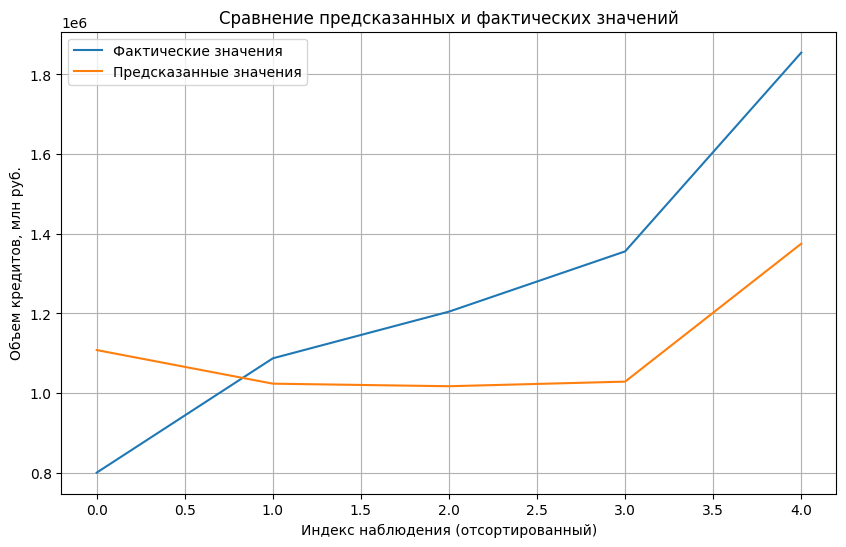

In [276]:
# Для красивой визуализации отсортируем данные по возрастанию фактических значений
sorted_indices = Ytest['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'].argsort()
Ytest_sorted = Ytest.iloc[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(Ytest_sorted.values, label='Фактические значения')
plt.plot(predictions_sorted, label='Предсказанные значения')
plt.xlabel('Индекс наблюдения (отсортированный)')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Сравнение предсказанных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

Выполним предсказание на 2025 год

In [260]:
predictions_2025 = regressor.predict(data_for_predict)
print(predictions)

[ 958631.35325995  965611.95819175  966387.26706359  965825.18678165
  991905.50279902  998866.90399061 1015089.59471026 1017155.79223715
 1020945.75998581 1020830.08066564 1020830.08066564]


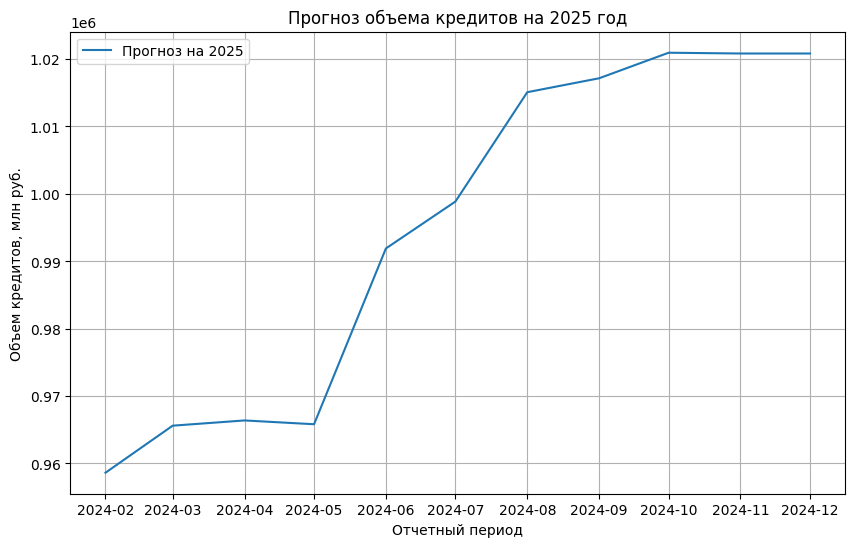

In [277]:
predictions_2025 = regressor.predict(data_for_predict)

plt.figure(figsize=(10, 6))
plt.plot(data_for_predict_in_memory['Отчетный период'], predictions_2025, label='Прогноз на 2025')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Прогноз объема кредитов на 2025 год')
plt.legend()
plt.grid(True)
plt.show() 